In [219]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error
from tcn import TCN
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.losses import Huber
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam


In [220]:
#load the data
data= pd.read_csv(r'C:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\starbucks_open_7year.csv')
data["Date"] = pd.to_datetime(data["Date"])
data =data.set_index("Date").sort_index()
data["Log_Open"] = np.log(data["Open"])
value = data[["Log_Open"]]
data.head()


,Unnamed: 0,Open,Time,Log_Open
Date,,,,
2017-11-13,0,56.81,1.510531e+09,4.039712
2017-11-14,1,56.47,1.510618e+09,4.033710
2017-11-15,2,56.82,1.510704e+09,4.039888
2017-11-16,3,56.92,1.510790e+09,4.041647
2017-11-17,4,57.24,1.510877e+09,4.047253


In [221]:
#checking for missing data
data.fillna(method='ffill', inplace=True)

C:\Users\Bhumika Reddy\AppData\Local\Temp\ipykernel_1580\2005070927.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [222]:
#smoothning the data using a moving average
data['Log_Open'] = data['Log_Open'].rolling(window=5).mean().fillna(data['Log_Open'])

C:\Users\Bhumika Reddy\AppData\Local\Temp\ipykernel_1580\449888427.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


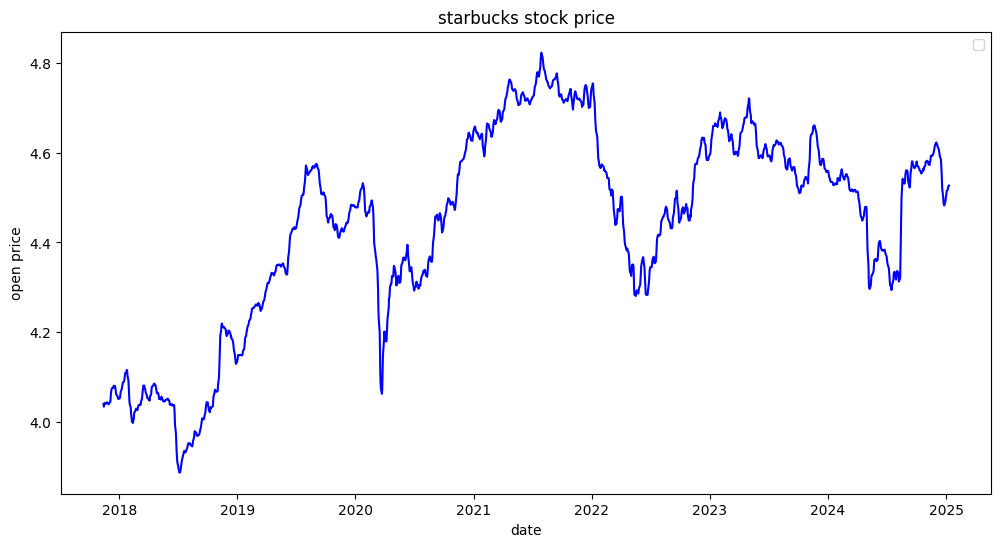

In [223]:
#visualizing the data
plt.figure(figsize=(12, 6))
plt.plot(data['Log_Open'], color='blue')
plt.title('starbucks stock price')
plt.xlabel('date')
plt.ylabel('open price')
plt.legend()
plt.show()

In [224]:
#scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Log_Open']])

In [225]:
#creating sequence
time_step=60
def create_sequences(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step-1):
        X.append(data[i:(i + time_step),0])
        Y.append(data[i + time_step,0])
    return np.array(X), np.array(Y)
X, Y = create_sequences(scaled_data, time_step)


In [226]:
#split data into train validate and test
train_size = 0.6 
validation_size = 0.2  
test_size = 0.2 

In [227]:

#split the data into training,validation and testing
train_size = int(len(scaled_data) * train_size)
validation_size = int(len(scaled_data) * validation_size)
test_size = len(scaled_data) - (train_size + validation_size)

# Split the data into training, validation, and test sets
train_data = scaled_data[:train_size]
validation_data = scaled_data[train_size:train_size + validation_size]
test_data = scaled_data[train_size + validation_size:]


In [228]:
#creating sequences
X_train, Y_train = create_sequences(train_data, time_step)
X_val, Y_val = create_sequences(validation_data, time_step)
X_test, Y_test = create_sequences(test_data, time_step)

In [229]:
#reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Print the shapes of the data sets
print("Training Data:", X_train.shape, Y_train.shape)
print("Validation Data:", X_val.shape, Y_val.shape)
print("Testing Data:", X_test.shape, Y_test.shape)

Training Data: (1019, 60, 1) (1019,)
Validation Data: (299, 60, 1) (299,)
Testing Data: (299, 60, 1) (299,)


In [230]:
#tcn model

model = Sequential()
model.add(TCN(input_shape=(X_train.shape[1], 1),nb_filters=128,kernel_size=3,nb_stacks=1,dilations=[1,2,4,8,16]))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['accuracy'])


c:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\venv\Lib\site-packages\tcn\tcn.py:263: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


In [231]:
#traim the model
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

lr_scheduler=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-4,verbose=1)

model.fit(X_train,Y_train,
          epochs=100,
          batch_size=32,
          validation_data=(X_val, Y_val),
          callbacks=[lr_scheduler])


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0040 - loss: 3.2722 - val_accuracy: 0.0000e+00 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0028 - loss: 0.1017 - val_accuracy: 0.0000e+00 - val_loss: 5.6481e-04 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0020 - loss: 0.0275 - val_accuracy: 0.0000e+00 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0015 - loss: 0.0213 - val_accuracy: 0.0000e+00 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0019 - loss: 0.0145 - val_accuracy: 0.0000e+00 - val_loss: 5.4296e-04 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0026 - loss: 0.0079 - val_accuracy: 0.0000e+00 - val_loss: 4.3068e-04 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 

In [232]:
test_loss = model.evaluate(X_test, Y_test)
train_loss = model.evaluate(X_train, Y_train)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 8.3001e-05
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0023 - loss: 2.2830e-05


In [233]:
#evaluation on scaled data
y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
mape = mean_absolute_percentage_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"Scaled MAE: {mae:.4f}")
print(f"Scaled MSE: {mse:.4f}")
print(f"Scaled MAPE: {mape:.4f}")
print(f"Scaled R2 Score: {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Scaled MAE: 0.0103
Scaled MSE: 0.0002
Scaled MAPE: 0.0159
Scaled R2 Score: 0.9803


In [234]:
#evaluating actual price predictions

y_pred_actual = scaler.inverse_transform(y_pred)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))
mae_actual = mean_absolute_error(Y_test_actual, y_pred_actual)
mse_actual = mean_squared_error(Y_test_actual, y_pred_actual)
mape_actual = mean_absolute_percentage_error(Y_test_actual, y_pred_actual)


In [235]:
print(f'Actual MAE: {mae_actual:.4f}')
print(f'Actual MSE: {mse_actual:.4f}')
print(f'Actual MAPE: {mape_actual:.4f}')



Actual MAE: 0.0097
Actual MSE: 0.0002
Actual MAPE: 0.0021


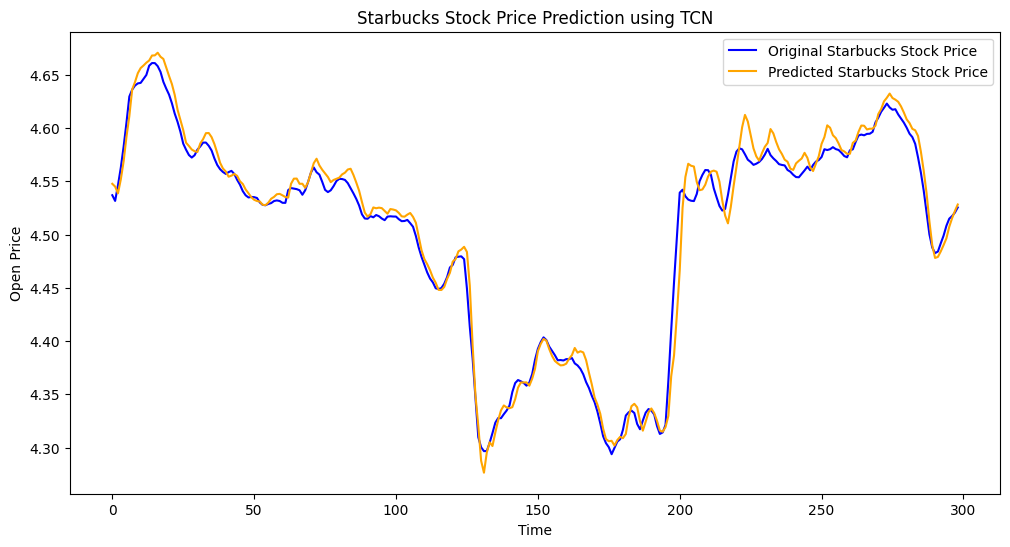

In [236]:
plt.figure(figsize=(12,6))
plt.plot(Y_test_actual, label='Original Starbucks Stock Price', color='blue')
plt.plot(y_pred_actual, label='Predicted Starbucks Stock Price', color='orange')
plt.title('Starbucks Stock Price Prediction using TCN')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.legend()
plt.show()

In [237]:
#actual prediction
def predict_stock(model, last_sequence, future_days):
  predictions = []
  current_sequence = last_sequence.copy()

  for i in range(future_days):
    current_input = current_sequence.reshape((1, time_step,1))
    next_prediction = model.predict(current_input)[0,0]
    predictions.append(next_prediction)

    current_sequence = np.roll(current_sequence,-1)
    current_sequence[-1] = next_prediction
  return scaler.inverse_transform(np.array(predictions).reshape(-1,1))

last_sequence = scaled_data[-time_step:]
future_predictions = predict_stock(model, last_sequence, 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

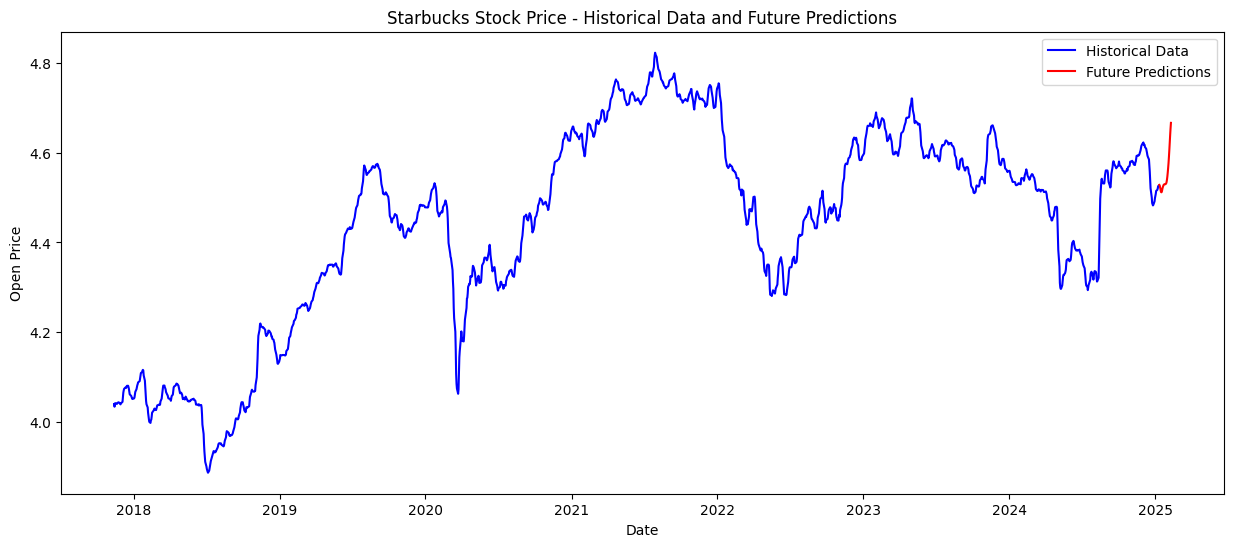

In [238]:

plt.figure(figsize=(15, 6))
plt.plot(data.index,data["Log_Open"], label="Historical Data", color= 'blue')
future_dates = pd.date_range(start=data.index[-1], periods=31, freq="D")[1:]
plt.plot(future_dates, future_predictions, "r-", label="Future Predictions")
plt.title('Starbucks Stock Price - Historical Data and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()